# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Reading Data

In [2]:
df = pd.read_csv("train_data.csv")

In [3]:
print("Number of rows in train data =", df.shape[0])
print("Number of columns in train data =", df.shape[1])

Number of rows in train data = 406572
Number of columns in train data = 12


In [4]:
df.head()

,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_bitrate_state,auto_fec_state,auto_fec_mean,stream_quality
0,24.4,0.516398,0,91.1,6.723921,0.0,0.0,0.0,off,partial,50.0,0
1,28.6,2.065591,0,99.7,15.923777,0.0,0.0,0.0,off,partial,50.0,0
2,30.0,0.000000,0,98.1,11.798776,0.0,0.0,0.0,off,partial,50.0,0
3,30.3,0.948683,0,99.4,13.014522,0.0,0.0,0.0,off,partial,50.0,0
4,29.9,0.316228,0,123.2,62.476307,0.0,0.0,0.0,off,partial,50.0,0


In [5]:
df.tail()

,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_bitrate_state,auto_fec_state,auto_fec_mean,stream_quality
406567,40.0,0.0,0,0.0,0.0,0.0,0.0,0.0,full,partial,50.0,0
406568,40.0,0.0,0,0.0,0.0,0.0,0.0,0.0,full,partial,50.0,0
406569,40.0,0.0,0,0.0,0.0,0.0,0.0,0.0,full,partial,50.0,0
406570,40.0,0.0,0,0.0,0.0,0.0,0.0,0.0,full,partial,50.0,0
406571,40.0,0.0,0,0.0,0.0,0.0,0.0,0.0,full,partial,50.0,0


# Exploratory Data Analysis (EDA)

We have done indeed analysis of some of our features in the Regression task, so we shall now do analysis on the new features.

### General Overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406572 entries, 0 to 406571
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   fps_mean             406572 non-null  float64
 1   fps_std              406572 non-null  float64
 2   fps_lags             406572 non-null  int64  
 3   rtt_mean             406572 non-null  float64
 4   rtt_std              406572 non-null  float64
 5   dropped_frames_mean  406572 non-null  float64
 6   dropped_frames_std   406572 non-null  float64
 7   dropped_frames_max   406572 non-null  float64
 8   auto_bitrate_state   406572 non-null  object 
 9   auto_fec_state       406572 non-null  object 
 10  auto_fec_mean        406572 non-null  float64
 11  stream_quality       406572 non-null  int64  
dtypes: float64(8), int64(2), object(2)
memory usage: 37.2+ MB


In [ ]:
df.isnull().sum()

fps_mean               0
fps_std                0
fps_lags               0
rtt_mean               0
rtt_std                0
dropped_frames_mean    0
dropped_frames_std     0
dropped_frames_max     0
auto_bitrate_state     0
auto_fec_state         0
auto_fec_mean          0
stream_quality         0
dtype: int64

So based on the previous output we don't have any missing values or any cells which containts nan or Null values, all of our features we have are numerical features but two of them are object(categorical) so we should apply preprocessing on those features later on.

### Variables Analysis

In [ ]:
# Creating seperate dataframe which contain only categorical variables
df_cat = df.select_dtypes(include = 'object').copy()
df_cat.head(2)

,auto_bitrate_state,auto_fec_state
0,off,partial
1,off,partial


In [ ]:
print("the unique values of auto_bitrate_state is", df_cat["auto_bitrate_state"].unique())
print("the unique values of auto_fec_state is", df_cat["auto_fec_state"].unique())

the unique values of auto_bitrate_state is ['off' 'full' 'partial']
the unique values of auto_fec_state is ['partial' 'off']


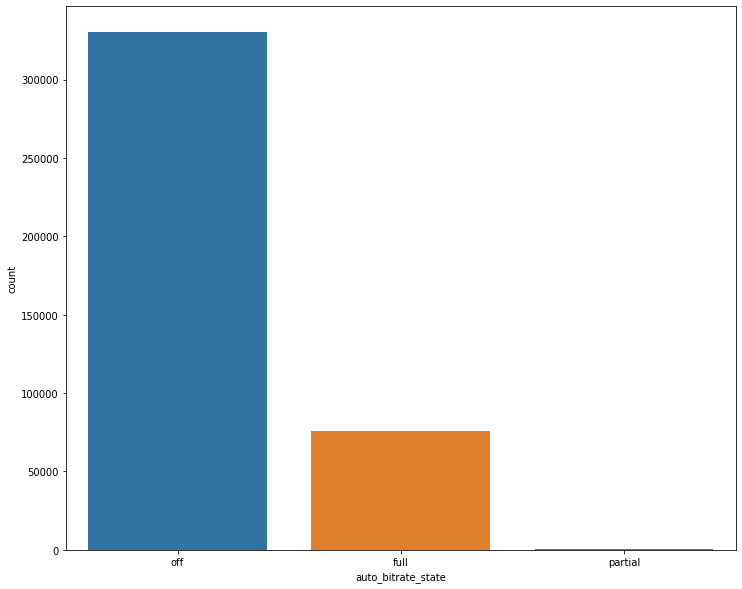

In [ ]:
plt.figure(figsize = (12, 10))
sns.countplot(data = df_cat, x = "auto_bitrate_state")
plt.show()

We can see that majority of data of the features auto_bitrate_state take the value off while the partial value is really small, let's check the numbers for more insight.

In [ ]:
df_cat["auto_bitrate_state"].value_counts()

off        330198
full        75964
partial       410
Name: auto_bitrate_state, dtype: int64

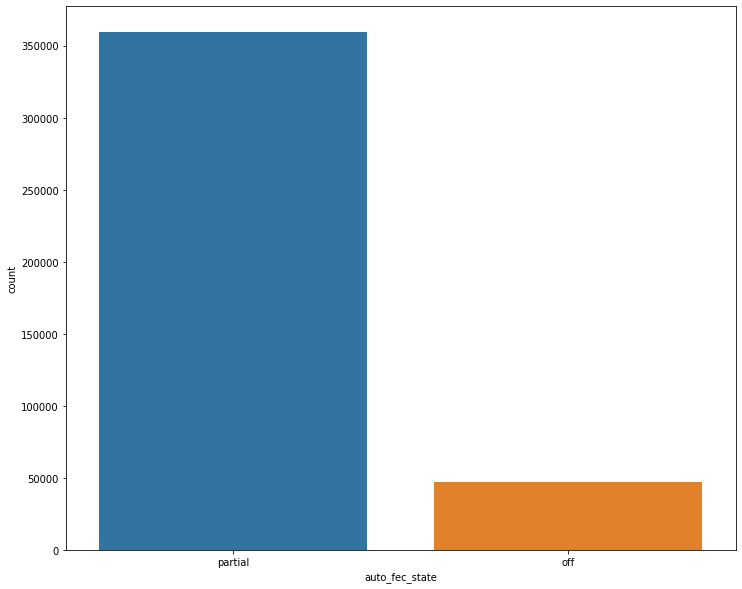

In [ ]:
plt.figure(figsize = (12, 10))
sns.countplot(data = df_cat, x = "auto_fec_state")
plt.show()

We can see here alos that majority of data of the features auto_fec_state take the value partial this time while the off value number is small, let's check the numbers for more insight.

In [ ]:
df_cat["auto_fec_state"].value_counts()

partial    359296
off         47276
Name: auto_fec_state, dtype: int64

AS we are working on a supervised ML problem we should also check the relationshipt between the dependent variable and independent variable. but first let's add our dependent variable to this dataset.

In [ ]:
df_cat["stream_quality"] = df.loc[df_cat.index, "stream_quality"].copy()

In [ ]:
df_cat.head()

,auto_bitrate_state,auto_fec_state,stream_quality
0,off,partial,0
1,off,partial,0
2,off,partial,0
3,off,partial,0
4,off,partial,0


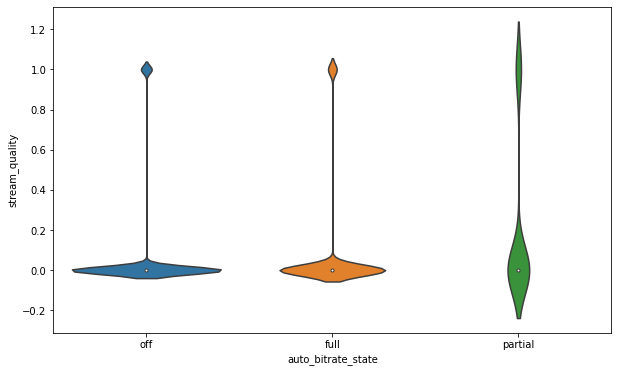

In [ ]:
plt.figure(figsize = (10, 6))
sns.violinplot(data = df_cat, x = "auto_bitrate_state", y = "stream_quality")
plt.show()

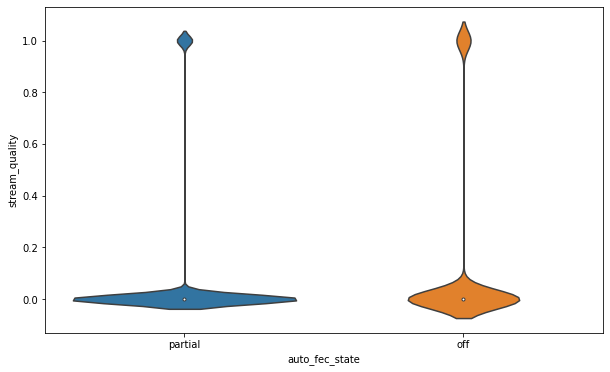

In [ ]:
plt.figure(figsize = (10, 6))
sns.violinplot(data = df_cat, x = "auto_fec_state", y = "stream_quality")
plt.show()

Now, from the violin plot we can see the distribution of each feature, and how it's connect with our target variable, as we can notice that regarding feature auto_bitrate_state, when we have off most of the time the target will be zero as similar to the feature auto_fec_state with partial value this time, for more let's calculate some intersection.

In [ ]:
print("Percetnage of times when auto_bitrate_state equal off and stream quality equal zero =", len(df_cat[(df_cat.auto_bitrate_state == "off") & (df_cat.stream_quality == 0.0)]) / len(df_cat[df_cat.stream_quality == 0.0]) * 100, '%')
print("Percetnage of times when auto_fec_state equal off and stream quality equal zero =", len(df_cat[(df_cat.auto_fec_state == "partial") & (df_cat.stream_quality == 0.0)]) / len(df_cat[df_cat.stream_quality == 0.0]) * 100, '%')

Percetnage of times when auto_bitrate_state equal off and stream quality equal zero = 81.38370060569576 %
Percetnage of times when auto_fec_state equal off and stream quality equal zero = 88.91951692198829 %


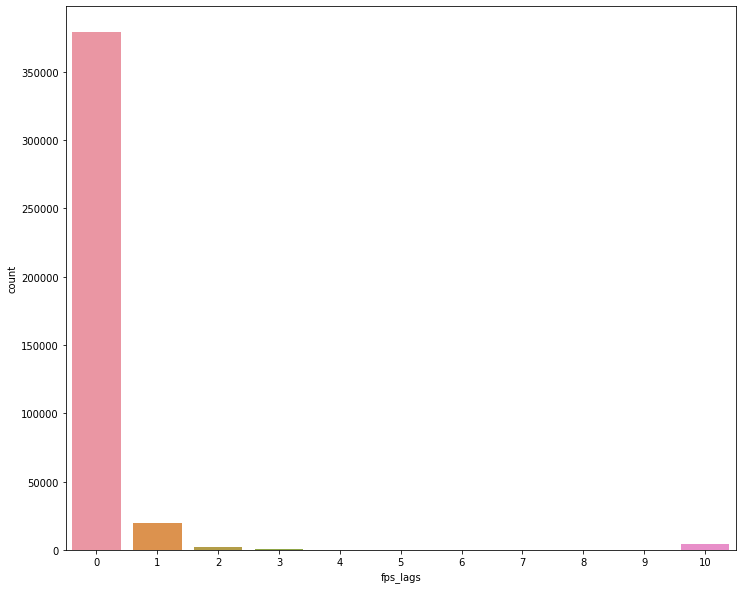

In [ ]:
plt.figure(figsize = (12, 10))
sns.countplot(data = df, x = "fps_lags")
plt.show()

In [ ]:
print("Percetnage of times when fps_lags equal zero and stream quality equal zero =", len(df[(df.fps_lags == 0) & (df.stream_quality == 0.0)]) / len(df[df.stream_quality == 0.0]) * 100, '%')

Percetnage of times when fps_lags equal zero and stream quality equal zero = 96.00198554145611 %


So we can notice easily how powerful are those three features to detect the quality of the stream based only one values of each, there is a high chance that those values will be a powerful predictors, Now let's see how our features contribute to split the data to 1 or 0, in other words we shall see now how can each feature on it's own can separate data linearley, but first we shall come back to our original dataset.

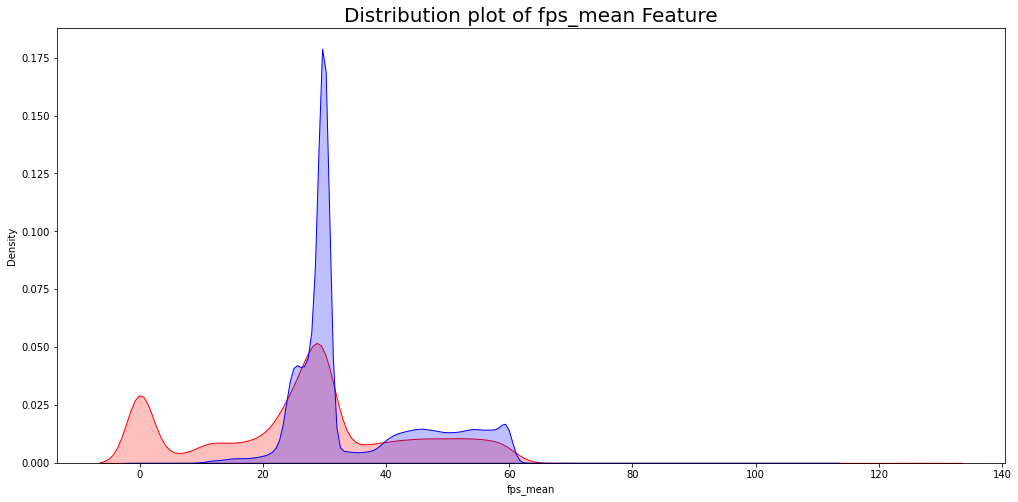

In [ ]:
plt.figure(figsize = (17, 8))

sns.kdeplot(df[df["stream_quality"] == 1]["fps_mean"], color = "red", fill = True)
sns.kdeplot(df[df["stream_quality"] == 0]["fps_mean"], color = "blue", fill = True)

plt.title("Distribution plot of fps_mean Feature", size = 20)
plt.show()

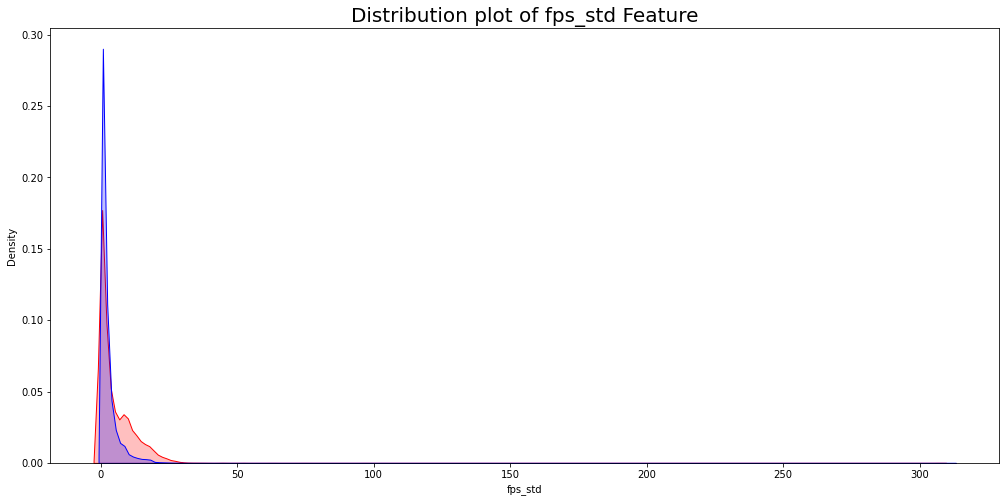

In [ ]:
plt.figure(figsize = (17, 8))

sns.kdeplot(df[df["stream_quality"] == 1]["fps_std"], color = "red", fill = True)
sns.kdeplot(df[df["stream_quality"] == 0]["fps_std"], color = "blue", fill = True)

plt.title("Distribution plot of fps_std Feature", size = 20)
plt.show()

We have some overlap here but there is some posibility that points with low fps_mean tend to give more 1 that points with high fps_mean, but we can't be sure because of the jagging shape of the data specially as zero value for stream quality (in blue) centered in the middle.

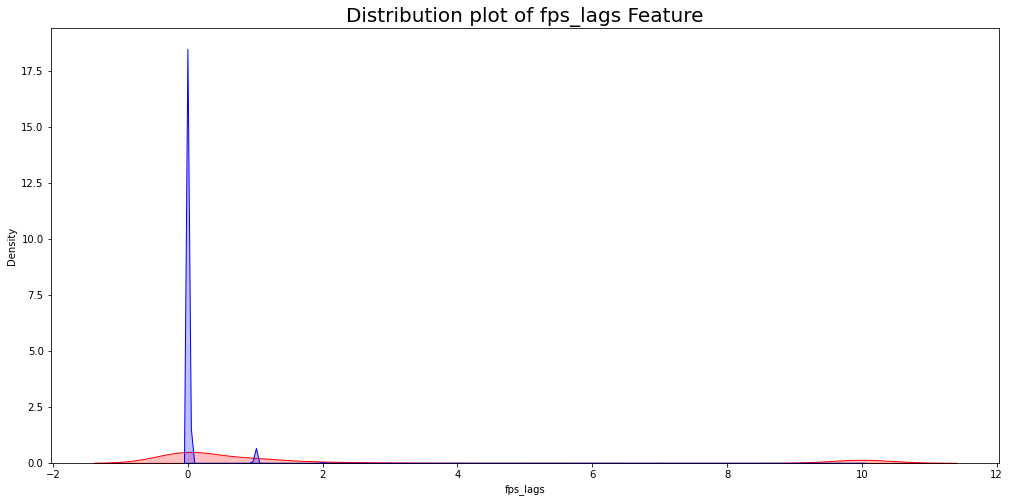

In [ ]:
plt.figure(figsize = (17, 8))

sns.kdeplot(df[df["stream_quality"] == 1]["fps_lags"], color = "red", fill = True)
sns.kdeplot(df[df["stream_quality"] == 0]["fps_lags"], color = "blue", fill = True)

plt.title("Distribution plot of fps_lags Feature", size = 20)
plt.show()

Points with stream quality equal to zero tend to gather togeather at value zero as we have saw earlier from count plot and from 96% percentage but with other values it's spread but it is much less than zero value.

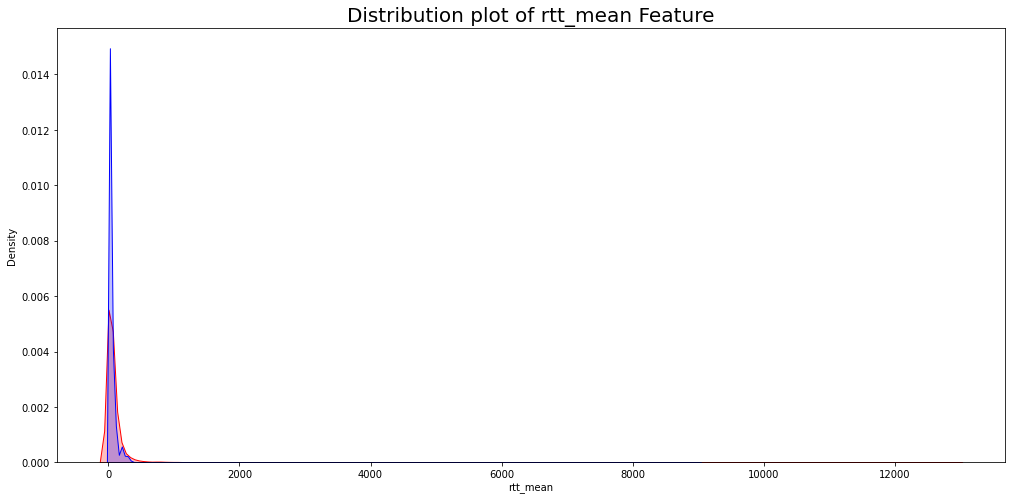

In [ ]:
plt.figure(figsize = (17, 8))

sns.kdeplot(df[df["stream_quality"] == 1]["rtt_mean"], color = "red", fill = True)
sns.kdeplot(df[df["stream_quality"] == 0]["rtt_mean"], color = "blue", fill = True)

plt.title("Distribution plot of rtt_mean Feature", size = 20)
plt.show()

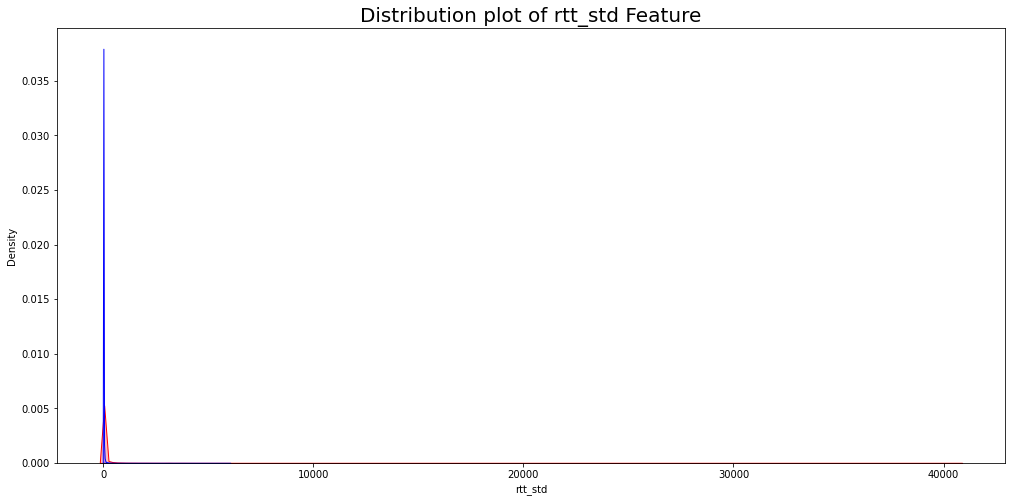

In [ ]:
plt.figure(figsize = (17, 8))

sns.kdeplot(df[df["stream_quality"] == 1]["rtt_std"], color = "red", fill = True)
sns.kdeplot(df[df["stream_quality"] == 0]["rtt_std"], color = "blue", fill = True)

plt.title("Distribution plot of rtt_std Feature", size = 20)
plt.show()

Those two features are completely overlaped for their values, we can't get prefernce of the selected class based on theire float values.

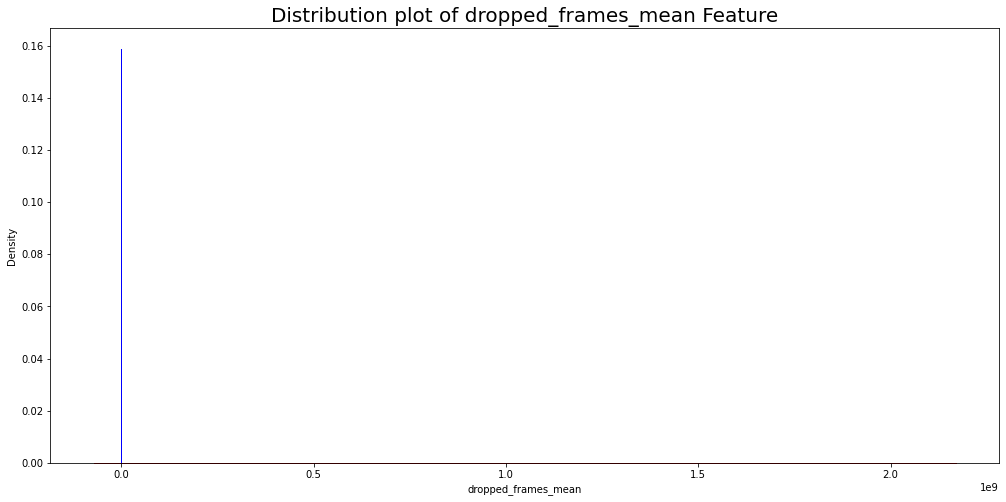

In [ ]:
plt.figure(figsize = (17, 8))

sns.kdeplot(df[df["stream_quality"] == 1]["dropped_frames_mean"], color = "red", fill = True)
sns.kdeplot(df[df["stream_quality"] == 0]["dropped_frames_mean"], color = "blue", fill = True)

plt.title("Distribution plot of dropped_frames_mean Feature", size = 20)
plt.show()

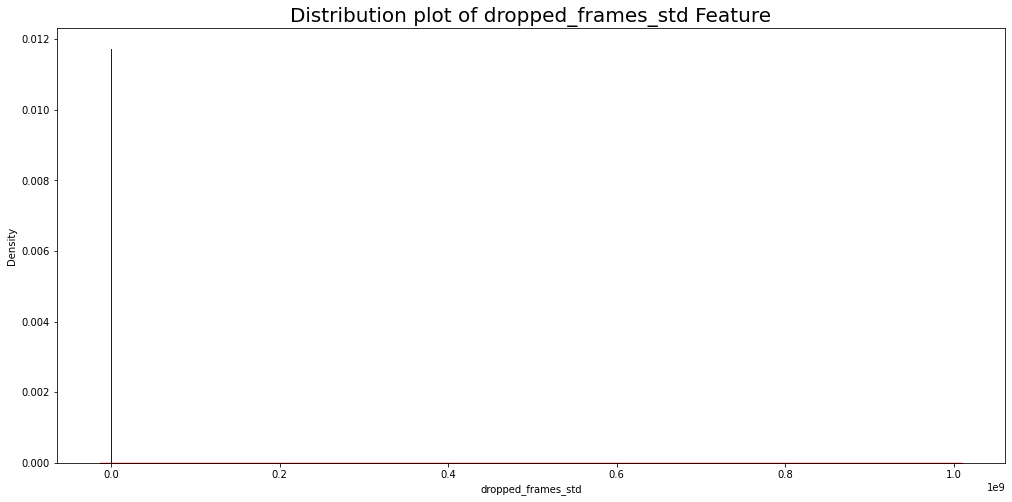

In [ ]:
plt.figure(figsize = (17, 8))

sns.kdeplot(df[df["stream_quality"] == 1]["dropped_frames_std"], color = "red", fill = True)
sns.kdeplot(df[df["stream_quality"] == 0]["dropped_frames_std"], color = "blue", fill = True)

plt.title("Distribution plot of dropped_frames_std Feature", size = 20)
plt.show()

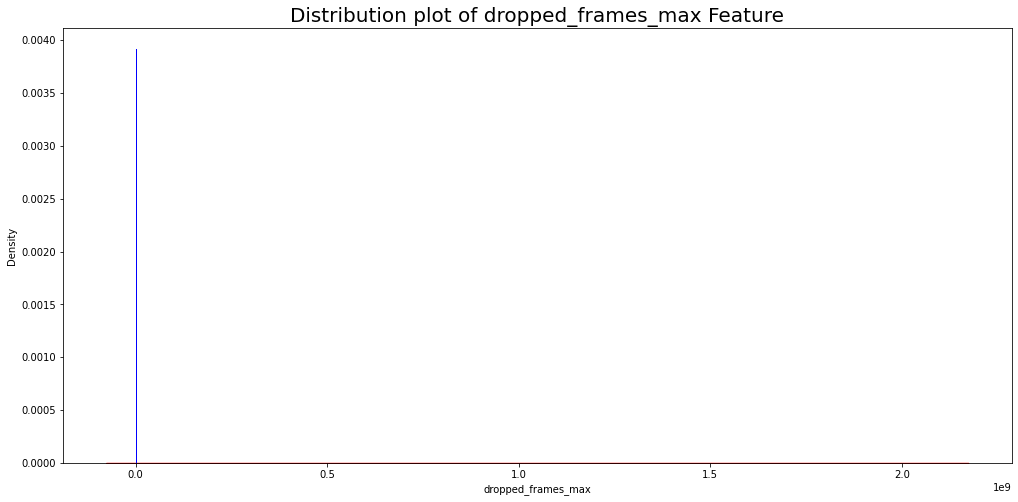

In [ ]:
plt.figure(figsize = (17, 8))

sns.kdeplot(df[df["stream_quality"] == 1]["dropped_frames_max"], color = "red", fill = True)
sns.kdeplot(df[df["stream_quality"] == 0]["dropped_frames_max"], color = "blue", fill = True)

plt.title("Distribution plot of dropped_frames_max Feature", size = 20)
plt.show()

There is a very large scale on those features but still their values gatherd on 0.0 for the class 0 and the other spread all around the scale.

# Data Cleaning and PreProcessing

### Process Categorical Variables

In [6]:
print("the categoraical variables / features in our dataset are as follow:")
df.select_dtypes(include = ["object"])

the categoraical variables / features in our dataset are as follow:


,auto_bitrate_state,auto_fec_state
0,off,partial
1,off,partial
2,off,partial
3,off,partial
4,off,partial
...,...,...
406567,full,partial
406568,full,partial
406569,full,partial
406570,full,partial


As our first categorical variable contain only two possible values, off or full, we can map it easilty to integer using pandas series Replace.

In [7]:
df["auto_fec_state"] = df["auto_fec_state"].replace({"off": 1, "partial": 0})

In [8]:
df.head()

,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_bitrate_state,auto_fec_state,auto_fec_mean,stream_quality
0,24.4,0.516398,0,91.1,6.723921,0.0,0.0,0.0,off,0,50.0,0
1,28.6,2.065591,0,99.7,15.923777,0.0,0.0,0.0,off,0,50.0,0
2,30.0,0.000000,0,98.1,11.798776,0.0,0.0,0.0,off,0,50.0,0
3,30.3,0.948683,0,99.4,13.014522,0.0,0.0,0.0,off,0,50.0,0
4,29.9,0.316228,0,123.2,62.476307,0.0,0.0,0.0,off,0,50.0,0


As we have only 3 possible values of the feature auto_bitrate_state we can easily conver it into the numerical space using one hot encoder without generating too much cardinality.

In [9]:
encoder = ce.one_hot.OneHotEncoder(verbose = 1, cols = ["auto_bitrate_state"], handle_unknown = 'ignore')
encoder.fit(df)
df = encoder.transform(df)

In [10]:
df.head()

,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_bitrate_state_1,auto_bitrate_state_2,auto_bitrate_state_3,auto_fec_state,auto_fec_mean,stream_quality
0,24.4,0.516398,0,91.1,6.723921,0.0,0.0,0.0,1,0,0,0,50.0,0
1,28.6,2.065591,0,99.7,15.923777,0.0,0.0,0.0,1,0,0,0,50.0,0
2,30.0,0.000000,0,98.1,11.798776,0.0,0.0,0.0,1,0,0,0,50.0,0
3,30.3,0.948683,0,99.4,13.014522,0.0,0.0,0.0,1,0,0,0,50.0,0
4,29.9,0.316228,0,123.2,62.476307,0.0,0.0,0.0,1,0,0,0,50.0,0


In [11]:
print("Number of columns in dataset after processing =", df.shape[1])

Number of columns in dataset after processing = 14


### Removing Outliers

Before removing outliers we should only check if our data contains any outliers, based on our past analysis of the data it seems that the dataset contains outliers, we should consider do more analysis to be suer that those extrem values could be considered as outliers.

As we have a skewed distributions for most of our features, we shall used IQR or Percentile method to detect outliers, then based on the number of those points we decide how to deal with them either by trimming, Capping or Binning.

In [12]:
def plot_boxplot(feature):
  sns.boxplot(df[feature])
  plt.show()

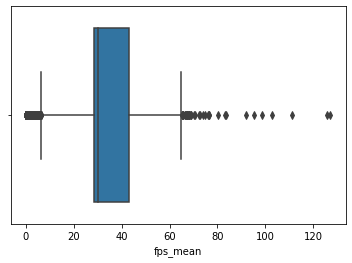

In [13]:
plot_boxplot("fps_mean")

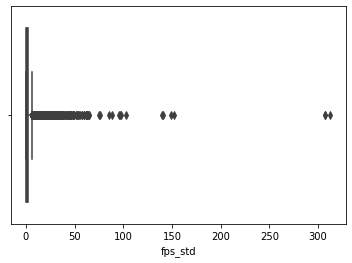

In [14]:
plot_boxplot("fps_std")

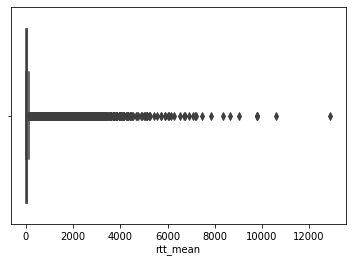

In [15]:
plot_boxplot("rtt_mean")

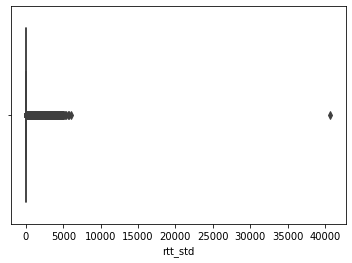

In [16]:
plot_boxplot("rtt_std")

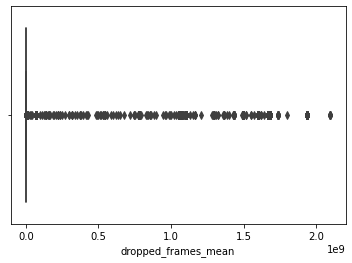

In [17]:
plot_boxplot("dropped_frames_mean")

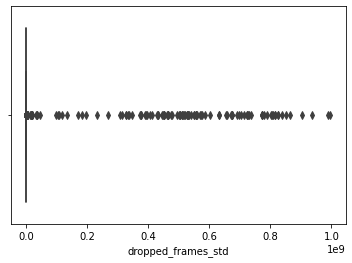

In [18]:
plot_boxplot("dropped_frames_std")

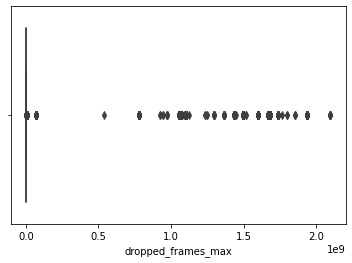

In [19]:
plot_boxplot("dropped_frames_max")

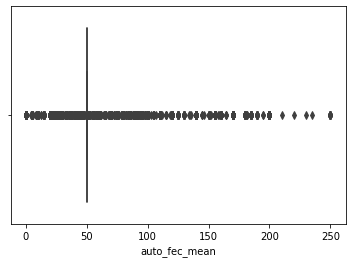

In [20]:
plot_boxplot("auto_fec_mean")

Based on our previous boxplot we can see that we have some outliers but not all points outside the whiskers to be considerd as outliers so we will relay on percentile method 

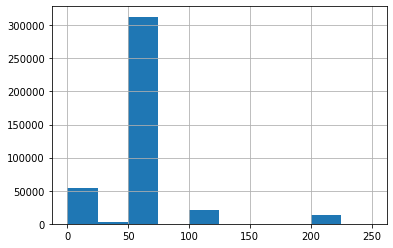

In [21]:
df.auto_fec_mean.hist()

In [22]:
def number_of_outliers(feature, threshold = 0.99):
  upper_limit = df[feature].quantile(threshold)
  num_of_outliers = len(df) - len(df[(df[feature] <= upper_limit)])
  print(f"number of outliers in feature {feature} =", num_of_outliers)

In [23]:
def get_upper_limit(feature, threshold = 0.99):
    return df[feature].quantile(threshold)

In [24]:
number_of_outliers("fps_mean")
number_of_outliers("fps_std")
number_of_outliers("rtt_mean")
number_of_outliers("rtt_std")
number_of_outliers("dropped_frames_mean")
number_of_outliers("dropped_frames_std")
number_of_outliers("dropped_frames_max")
number_of_outliers("auto_fec_mean")

number of outliers in feature fps_mean = 3250
number of outliers in feature fps_std = 4066
number of outliers in feature rtt_mean = 4065
number of outliers in feature rtt_std = 4066
number of outliers in feature dropped_frames_mean = 4052
number of outliers in feature dropped_frames_std = 4009
number of outliers in feature dropped_frames_max = 4000
number of outliers in feature auto_fec_mean = 17


In [25]:
def remove_outliers(data):
  for col in data.columns:
    data = data[(data[col] <= get_upper_limit(col))]
  return data

In [26]:
before = len(df)
print("Number of data points before removing outliers =", len(df))

Number of data points before removing outliers = 406572


In [27]:
df = remove_outliers(df)
print("Number of data points after removing outliers =", len(df))
print("Number of removed data points =", before - len(df))

Number of data points after removing outliers = 390235
Number of removed data points = 16337


### Features Scaling

Before we do feature scaling we are goint to plot heatmap pearson correlation matrix to see what is the most correlated features to our target variable, if we exclude the categroical varibale as we have already notice that those variables are important, so we will run this only on numberical variables.

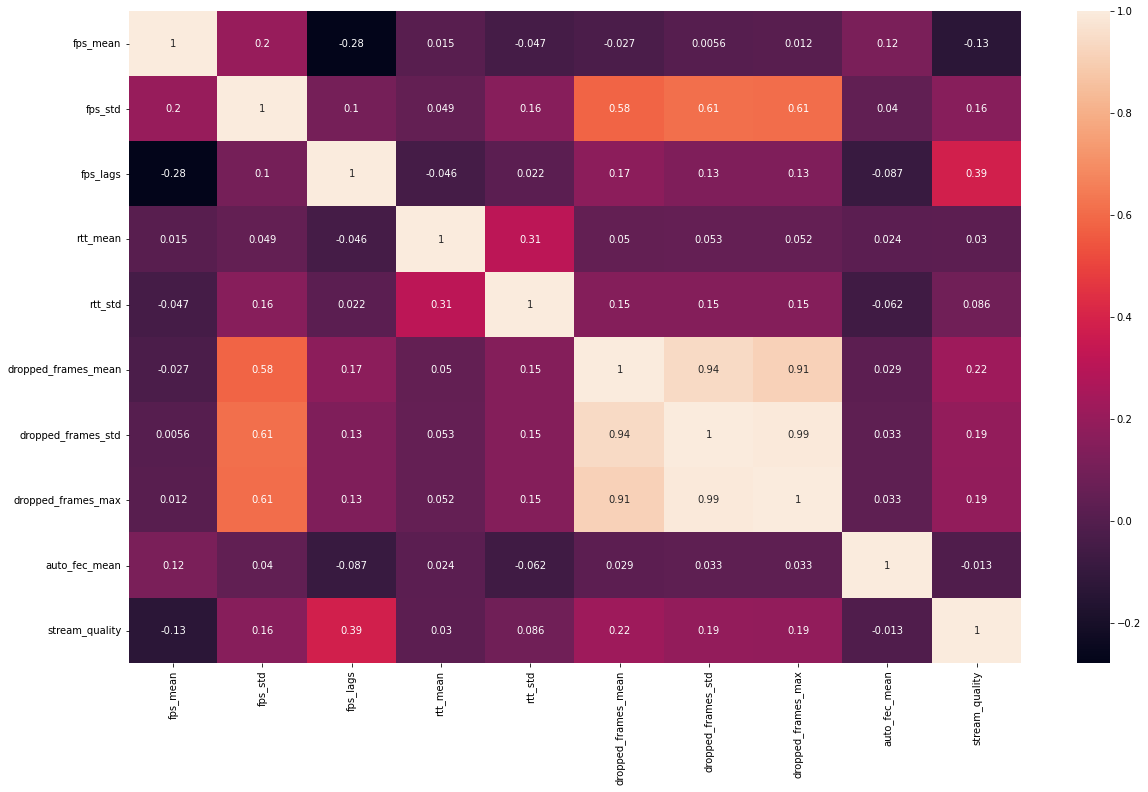

In [28]:
plt.figure(figsize = (20, 12))
sns.heatmap(df.drop(['auto_bitrate_state_1', 'auto_bitrate_state_2', 'auto_bitrate_state_3',
       'auto_fec_state'], axis = 1).corr(method = "pearson"), annot = True)
plt.show()

The most correlated features are in the following orders:

1. FPS_lags ( we conclude eariler that this featuers are improtant by analysis of it's values)

2. dropped_frames_mean

3. dropped_frames_max / dropped_frames_std

4. fps_std

In [29]:
x_train, x_val, y_train, y_val = train_test_split(df[df.columns[:-1]], df["stream_quality"], test_size = 0.1)

In [30]:
x_train.columns

Index(['fps_mean', 'fps_std', 'fps_lags', 'rtt_mean', 'rtt_std',
       'dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max',
       'auto_bitrate_state_1', 'auto_bitrate_state_2', 'auto_bitrate_state_3',
       'auto_fec_state', 'auto_fec_mean'],
      dtype='object')

In [31]:
x_val.columns

Index(['fps_mean', 'fps_std', 'fps_lags', 'rtt_mean', 'rtt_std',
       'dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max',
       'auto_bitrate_state_1', 'auto_bitrate_state_2', 'auto_bitrate_state_3',
       'auto_fec_state', 'auto_fec_mean'],
      dtype='object')

In [32]:
print("Number or rows in train data =", len(x_train))
print("Number or rows in validation data =", len(x_val))

print("Number or rows in target train data =", len(y_train))
print("Number or rows in target validation data =", len(y_val))

Number or rows in train data = 351211
Number or rows in validation data = 39024
Number or rows in target train data = 351211
Number or rows in target validation data = 39024


In [33]:
print("Number or columns in train data =", x_train.shape[1])
print("Number or column in validation data =", x_val.shape[1])

Number or columns in train data = 13
Number or column in validation data = 13


In [34]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [35]:
def print_rows(data, n_rows):
  for i in range(n_rows):
    print(data[i])

In [36]:
# Checking The result of scaling our data
n_rows = 5
print(f"printing the top five {n_rows} of training data")
print_rows(x_train, n_rows)

printing the top five 5 of training data
[0.79632721 0.03825164 0.         0.13169985 0.00197298 0.
 0.         0.         1.         0.         0.         0.
 0.25      ]
[0.85642738 0.05376513 0.         0.17427259 0.00218369 0.
 0.         0.         1.         0.         0.         0.
 0.25      ]
[0.50083472 0.         0.         0.05880551 0.00620785 0.
 0.         0.         1.         0.         0.         0.
 1.        ]
[0.76293823 0.74184719 0.         0.12986217 0.00152827 0.3125
 0.73863636 0.73863636 0.         1.         0.         0.
 0.25      ]
[0.74958264 0.48344345 0.         0.08912711 0.01537472 0.
 0.         0.         1.         0.         0.         1.
 0.        ]


In [37]:
n_rows = 5
print(f"printing the top five {n_rows} of validataion data")
print_rows(x_val, n_rows)

printing the top five 5 of validataion data
[0.4490818  0.09040156 0.         0.16875957 0.00167993 0.
 0.         0.         1.         0.         0.         0.
 0.25      ]
[5.00834725e-01 0.00000000e+00 0.00000000e+00 1.25574273e-02
 9.35868041e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.50000000e-01]
[0.94156928 0.0609221  0.         0.04808576 0.00558915 0.
 0.         0.         1.         0.         0.         0.
 1.        ]
[0.50417362 0.03584342 0.         0.13323124 0.00672698 0.
 0.         0.         1.         0.         0.         0.
 0.25      ]
[0.51752922 0.03778228 0.         0.04839204 0.01157184 0.
 0.         0.         1.         0.         0.         1.
 0.        ]


### Feature Selection (Statistical / Filter Method)

The features are selected independently of any machine learning algorithms. Using statistics (e.g., Pearson’s Correlation, LDA, etc.), we select important features based on how each feature impacts the target outcome. This is the least compute-intensive and fastest methodology.

The correlation matrix will help us to identify the highly correlated features. we should note that sometimes pandas profiling report takes time to generate, so it is essential to know other techniques to plot the correlation matrix.

In [38]:
columns = ['fps_mean', 'fps_std', 'fps_lags', 'rtt_mean', 'rtt_std',
       'dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max',
       'auto_bitrate_state_1', 'auto_bitrate_state_2', 'auto_bitrate_state_3',
       'auto_fec_state', 'auto_fec_mean']

# regenerating dataframe out of numpy array
x_train = pd.DataFrame(x_train, columns =  columns)
x_val = pd.DataFrame(x_val, columns = columns)

In [39]:
# Chi-Square Feature Selection
selector = SelectKBest(chi2, k = 5)
selector.fit(x_train, y_train)
chi_support = selector.get_support()
x_train_new = pd.DataFrame(x_train, columns = columns)
x_val_new = pd.DataFrame(x_val, columns = columns)
# chi_support = list(map(int, chi_support))
chi_feature = x_train.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print("The selectd features are:", chi_feature)

# Removing unwanted features
x_train_new, x_cv_new = x_train_new[chi_feature], x_val_new[chi_feature]

5 selected features
The selectd features are: ['fps_std', 'fps_lags', 'dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max']


We can see exactly that those features the same as we got from the pearson correlation method, so we will create new dataset based on those featuers only plus categorical one hot encoded features and we will also keep the full dataset for the sake of comparsion later on when we build the models, as we did exactly with regression task.

In [40]:
x_train_new = x_train[['fps_std', 'fps_lags', 'dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max', 'fps_std', 'fps_lags', 'dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max']]
x_val_new = x_val[['fps_std', 'fps_lags', 'dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max', 'fps_std', 'fps_lags', 'dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max']]

In [41]:
x_train_new.head()

,fps_std,fps_lags,dropped_frames_mean,dropped_frames_std,dropped_frames_max,fps_std,fps_lags,dropped_frames_mean,dropped_frames_std,dropped_frames_max
0,0.038252,0.0,0.0000,0.000000,0.000000,0.038252,0.0,0.0000,0.000000,0.000000
1,0.053765,0.0,0.0000,0.000000,0.000000,0.053765,0.0,0.0000,0.000000,0.000000
2,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000
3,0.741847,0.0,0.3125,0.738636,0.738636,0.741847,0.0,0.3125,0.738636,0.738636
4,0.483443,0.0,0.0000,0.000000,0.000000,0.483443,0.0,0.0000,0.000000,0.000000


In [42]:
x_val_new.head()

,fps_std,fps_lags,dropped_frames_mean,dropped_frames_std,dropped_frames_max,fps_std,fps_lags,dropped_frames_mean,dropped_frames_std,dropped_frames_max
0,0.090402,0.0,0.0,0.0,0.0,0.090402,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.060922,0.0,0.0,0.0,0.0,0.060922,0.0,0.0,0.0,0.0
3,0.035843,0.0,0.0,0.0,0.0,0.035843,0.0,0.0,0.0,0.0
4,0.037782,0.0,0.0,0.0,0.0,0.037782,0.0,0.0,0.0,0.0


In [43]:
print("Number of feauters in x_train_new = ", x_train_new.shape[1])
print("Number of feauters in x_val_new = ", x_train_new.shape[1])

Number of feauters in x_train_new =  10
Number of feauters in x_val_new =  10


### Whole Data Visulaization

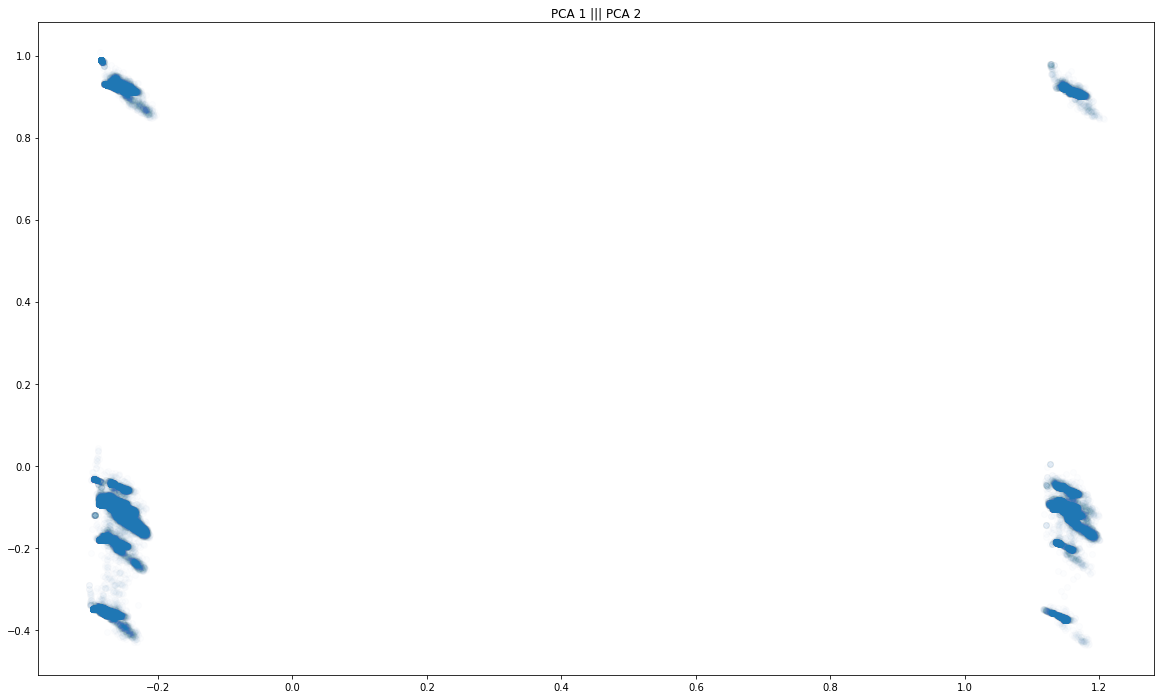

In [ ]:
pca = PCA(n_components = 2).fit(x_train)
x_train_pca = pca.transform(x_train)

plt.figure(figsize = (20, 12))
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], alpha = 0.01)
plt.title("PCA 1 ||| PCA 2")

plt.show()

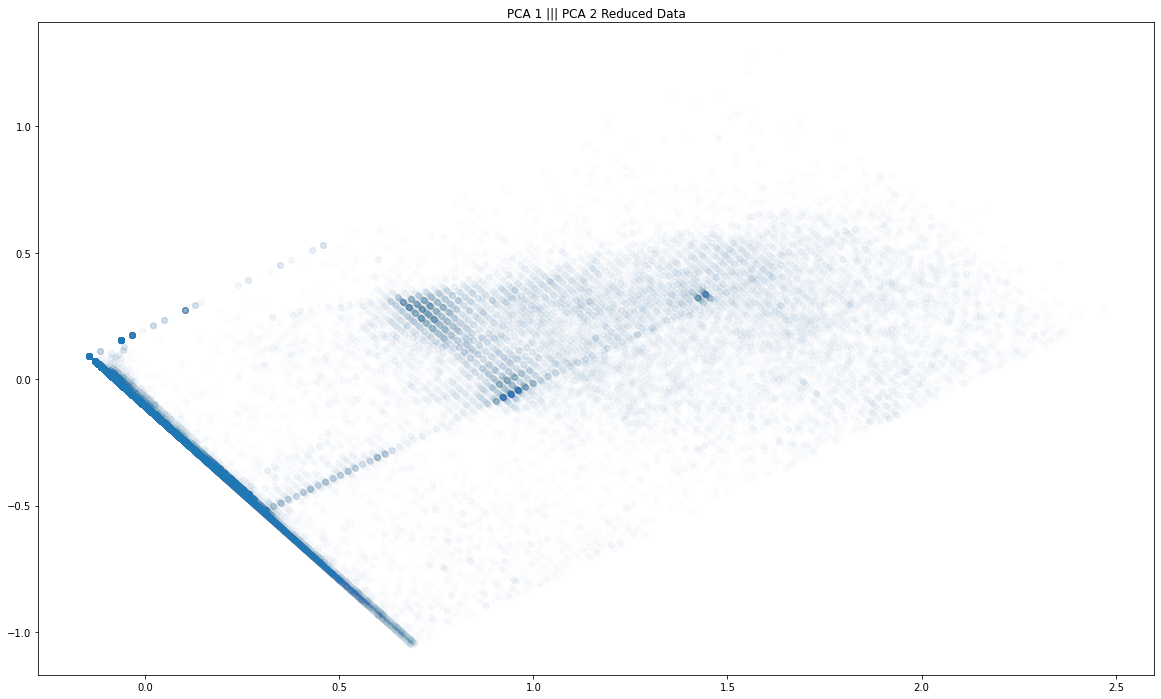

In [ ]:
pca = PCA(n_components = 2).fit(x_train_new)
x_train_pca = pca.transform(x_train_new)

plt.figure(figsize = (20, 12))
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], alpha = 0.01)
plt.title("PCA 1 ||| PCA 2 Reduced Data")

plt.show()

# Bulding Models

We will train 2 kinds of models for our Classification task:

2. Logistc Regression with Ridge Regulariztion with data balancing
4. Logistc Regression with Lasso Regulariztion with data balancing

We will play with our regularization parameter on our cross validataion data, hence we can expect also some unreliable results because of some duplicated data, we could eliminate them but we would lose some cardinality from some featuers, we can deal with this issue later on.

Then we will compare our results on whole features with reduced dataset which containt 10 featuers rather than 13

But before we build any models, we shall check our distribuiton of target variable in order to see how unbalanced our dataset is, we could do it eariler but i intedned to left it till now to catchy with model perforamce.

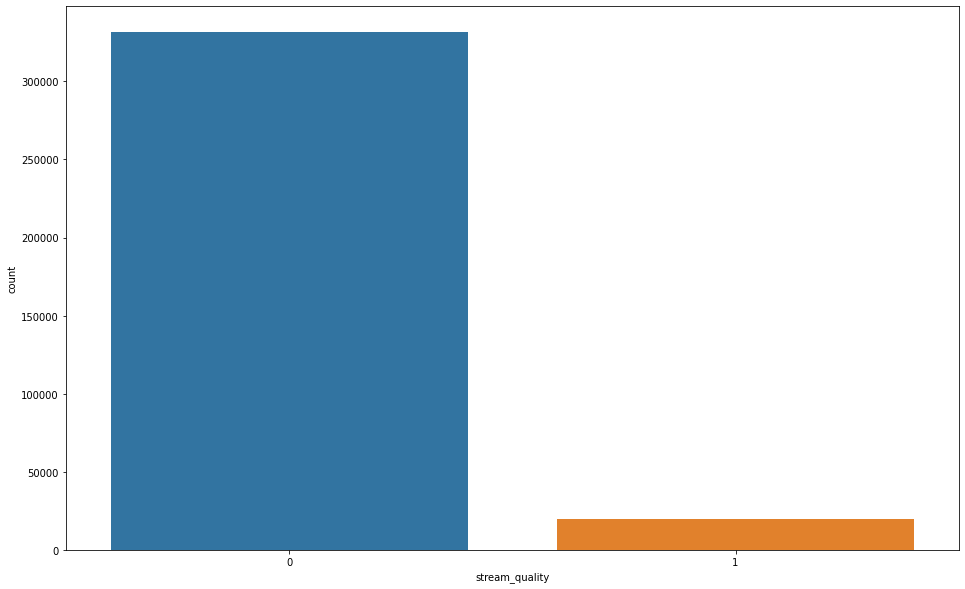

In [85]:
plt.figure(figsize = (16, 10))
sns.countplot(y_train)

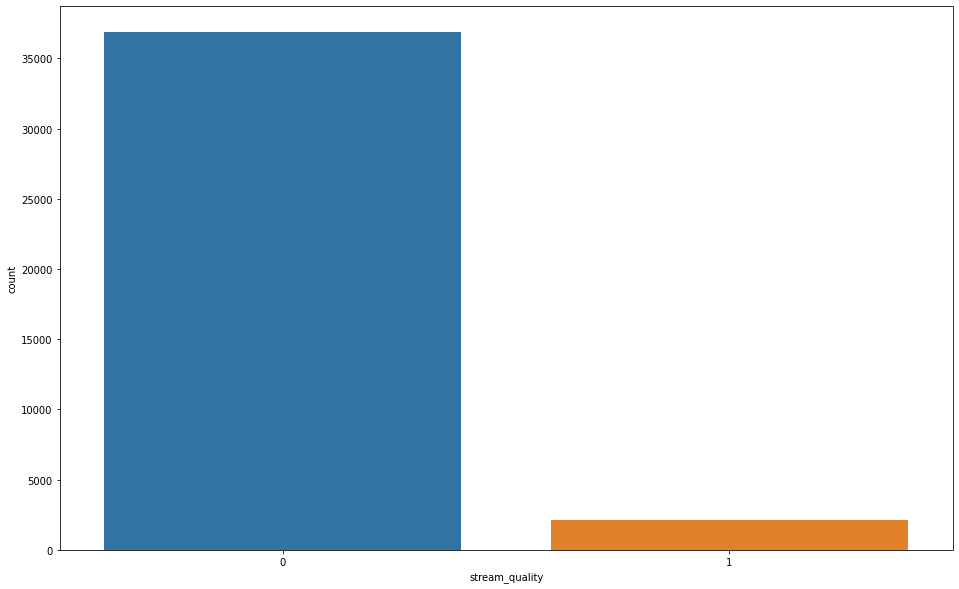

In [86]:
plt.figure(figsize = (16, 10))
sns.countplot(y_val)

In [87]:
y_train.value_counts()

0    331501
1     19710
Name: stream_quality, dtype: int64

In [88]:
y_val.value_counts()

0    36873
1     2151
Name: stream_quality, dtype: int64

### Logistc Regression with Ridge Regulariztion without Data Balancing

In [44]:
C = [0.01, 0.1, 1]
res2_train_accuracy, res2_train_precision, res2_train_recall, res2_train_f1, res2_train_f1_w = [], [], [], [], []
res2_val_accuracy, res2_val_precision, res2_val_recall, res2_val_f1, res2_val_f1_w = [], [], [], [], []
threshold = 0.75

for c in C:
  clf = LogisticRegression(penalty = "l2", C = c, n_jobs = -1)
  clf.fit(x_train, y_train)
  
  acc_train = accuracy_score(y_train, clf.predict_proba(x_train)[:, 1] >= threshold)
  pre_train = precision_score(y_train, clf.predict_proba(x_train)[:, 1] >= threshold)
  rec_train = recall_score(y_train, clf.predict_proba(x_train)[:, 1] >= threshold)
  f1_t = f1_score(y_train, clf.predict_proba(x_train)[:, 1] >= threshold)
  f1_w_t = f1_score(y_train, clf.predict_proba(x_train)[:, 1] >= threshold, average = "weighted")

  acc_val = accuracy_score(y_val, clf.predict_proba(x_val)[:, 1] >= threshold)
  pre_val = precision_score(y_val, clf.predict_proba(x_val)[:, 1] >= threshold)
  rec_val = recall_score(y_val, clf.predict_proba(x_val)[:, 1] >= threshold)
  f1_v = f1_score(y_val, clf.predict_proba(x_val)[:, 1] >= threshold)
  f1_w_v = f1_score(y_val, clf.predict_proba(x_val)[:, 1] >= threshold, average = "weighted")  
  
  clf.fit(x_train_new, y_train)
  
  acc_train_new = accuracy_score(y_train, clf.predict_proba(x_train_new)[:, 1] >= threshold)
  pre_train_new = precision_score(y_train, clf.predict_proba(x_train_new)[:, 1] >= threshold)
  rec_train_new = recall_score(y_train, clf.predict_proba(x_train_new)[:, 1] >= threshold)
  f1_t_new = f1_score(y_train, clf.predict_proba(x_train_new)[:, 1] >= threshold)
  f1_w_t_new = f1_score(y_train, clf.predict_proba(x_train_new)[:, 1] >= threshold, average = "weighted")

  acc_val_new = accuracy_score(y_val, clf.predict_proba(x_val_new)[:, 1] >= threshold)
  pre_val_new = precision_score(y_val, clf.predict_proba(x_val_new)[:, 1] >= threshold)
  rec_val_new = recall_score(y_val, clf.predict_proba(x_val_new)[:, 1] >= threshold)
  f1_v_new = f1_score(y_val, clf.predict_proba(x_val_new)[:, 1] >= threshold)
  f1_w_v_new = f1_score(y_val, clf.predict_proba(x_val_new)[:, 1] >= threshold, average = "weighted")

  res2_train_accuracy.append((acc_train, acc_train_new))
  res2_train_precision.append((pre_train, pre_train_new))
  res2_train_recall.append((rec_train, rec_train_new))
  res2_train_f1.append((f1_t, f1_t_new))
  res2_train_f1_w.append((f1_w_t, f1_w_t_new))

  res2_val_accuracy.append((acc_val, acc_val_new))
  res2_val_precision.append((pre_val, pre_val_new))
  res2_val_recall.append((rec_val, rec_val_new))
  res2_val_f1.append((f1_v, f1_v_new))
  res2_val_f1_w.append((f1_w_v, f1_w_v_new))

In [45]:
i = 0
for c in C:
  print(f"With C = {c} train accuracy = {res2_train_accuracy[i][0]} and train accuracy with redueced data = {res2_train_accuracy[i][1]}")
  print(f"With C = {c} validation accuracy = {res2_val_accuracy[i][0]} and validation accuracy with redueced data = {res2_val_accuracy[i][1]}")
  print("*" * 125)
  
  print(f"With C = {c} train precesion = {res2_train_precision[i][0]} and train precision with redueced data = {res2_train_precision[i][1]}")
  print(f"With C = {c} validation precision = {res2_val_precision[i][0]} and validation precision with redueced data = {res2_val_precision[i][1]}")
  print("*" * 125)
  
  print(f"With C = {c} train recall = {res2_train_recall[i][0]} and train recall with redueced data = {res2_train_recall[i][1]}")
  print(f"With C = {c} validation recall = {res2_val_recall[i][0]} and validation recall with redueced data = {res2_val_recall[i][1]}")
  print("*" * 125)

  print(f"With C = {c} train f1 = {res2_train_f1[i][0]} and train f1 with redueced data = {res2_train_f1[i][1]}")
  print(f"With C = {c} validation f1 = {res2_val_f1[i][0]} and validation f1 with redueced data = {res2_val_f1[i][1]}")
  print("*" * 125)

  print(f"With C = {c} train f1 weighted = {res2_train_f1_w[i][0]} and train f1 weighted with redueced data = {res2_train_f1_w[i][1]}")
  print(f"With C = {c} validation f1 weighted = {res2_val_f1_w[i][0]} and validation f1 weighted with redueced data = {res2_val_f1_w[i][1]}")
  print("*" * 125)

  i += 1

With C = 0.01 train accuracy = 0.9506365119543523 and train accuracy with redueced data = 0.9506279700806638
With C = 0.01 validation accuracy = 0.9492363673636737 and validation accuracy with redueced data = 0.9490313653136532
*****************************************************************************************************************************
With C = 0.01 train precesion = 0.9808917197452229 and train precision with redueced data = 0.9841609589041096
With C = 0.01 validation precision = 0.9793103448275862 and validation precision with redueced data = 0.9753521126760564
*****************************************************************************************************************************
With C = 0.01 train recall = 0.11784511784511785 and train recall with redueced data = 0.11728395061728394
With C = 0.01 validation recall = 0.12571934484285083 and validation recall with redueced data = 0.12262062859672422
****************************************************************

### Logistc Regression with Ridge Regulariztion with Data Balancing

In [46]:
C = [0.01, 0.1, 1]
res1_train_accuracy, res1_train_precision, res1_train_recall, res1_train_f1, res1_train_f1_w = [], [], [], [], []
res1_val_accuracy, res1_val_precision, res1_val_recall, res1_val_f1, res1_val_f1_w = [], [], [], [], []
threshold = 0.75

for c in C:
  clf1 = LogisticRegression(penalty = "l2", C = c, n_jobs = -1, class_weight = "balanced")
  clf1.fit(x_train, y_train)
  
  acc_train = accuracy_score(y_train, clf1.predict_proba(x_train)[:, 1] >= threshold)
  pre_train = precision_score(y_train, clf1.predict_proba(x_train)[:, 1] >= threshold)
  rec_train = recall_score(y_train, clf1.predict_proba(x_train)[:, 1] >= threshold)
  f1_t = f1_score(y_train, clf1.predict_proba(x_train)[:, 1] >= threshold)
  f1_w_t = f1_score(y_train, clf1.predict_proba(x_train)[:, 1] >= threshold, average = "weighted")

  acc_val = accuracy_score(y_val, clf1.predict_proba(x_val)[:, 1] >= threshold)
  pre_val = precision_score(y_val, clf1.predict_proba(x_val)[:, 1] >= threshold)
  rec_val = recall_score(y_val, clf1.predict_proba(x_val)[:, 1] >= threshold)
  f1_v = f1_score(y_val, clf1.predict_proba(x_val)[:, 1] >= threshold)
  f1_w_v = f1_score(y_val, clf1.predict_proba(x_val)[:, 1] >= threshold, average = "weighted")
  
  clf1.fit(x_train_new, y_train)
  
  acc_train_new = accuracy_score(y_train, clf1.predict_proba(x_train_new)[:, 1] >= threshold)
  pre_train_new = precision_score(y_train, clf1.predict_proba(x_train_new)[:, 1] >= threshold)
  rec_train_new = recall_score(y_train, clf1.predict_proba(x_train_new)[:, 1] >= threshold)
  f1_t_new = f1_score(y_train, clf1.predict_proba(x_train_new)[:, 1] >= threshold)
  f1_w_t_new = f1_score(y_train, clf1.predict_proba(x_train_new)[:, 1] >= threshold, average = "weighted")

  acc_val_new = accuracy_score(y_val, clf1.predict_proba(x_val_new)[:, 1] >= threshold)
  pre_val_new = precision_score(y_val, clf1.predict_proba(x_val_new)[:, 1] >= threshold)
  rec_val_new = recall_score(y_val, clf1.predict_proba(x_val_new)[:, 1] >= threshold)
  f1_v_new = f1_score(y_val, clf1.predict_proba(x_val_new)[:, 1] >= threshold)
  f1_w_v_new = f1_score(y_val, clf1.predict_proba(x_val_new)[:, 1] >= threshold, average = "weighted")

  res1_train_accuracy.append((acc_train, acc_train_new))
  res1_train_precision.append((pre_train, pre_train_new))
  res1_train_recall.append((rec_train, rec_train_new))
  res1_train_f1.append((f1_t, f1_t_new))
  res1_train_f1_w.append((f1_w_t, f1_w_t_new))

  res1_val_accuracy.append((acc_val, acc_val_new))
  res1_val_precision.append((pre_val, pre_val_new))
  res1_val_recall.append((rec_val, rec_val_new))
  res1_val_f1.append((f1_v, f1_v_new))
  res1_val_f1_w.append((f1_w_v, f1_w_v_new))

In [47]:
i = 0
for c in C:
  print(f"With C = {c} train accuracy = {res1_train_accuracy[i][0]} and train accuracy with redueced data = {res1_train_accuracy[i][1]}")
  print(f"With C = {c} validation accuracy = {res2_val_accuracy[i][0]} and validation accuracy with redueced data = {res2_val_accuracy[i][1]}")
  print("*" * 125)
  
  print(f"With C = {c} train precesion = {res1_train_precision[i][0]} and train precision with redueced data = {res1_train_precision[i][1]}")
  print(f"With C = {c} validation precision = {res1_val_precision[i][0]} and validation precision with redueced data = {res1_val_precision[i][1]}")
  print("*" * 125)
  
  print(f"With C = {c} train recall = {res1_train_recall[i][0]} and train recall with redueced data = {res1_train_recall[i][1]}")
  print(f"With C = {c} validation recall = {res1_val_recall[i][0]} and validation recall with redueced data = {res1_val_recall[i][1]}")
  print("*" * 125)

  print(f"With C = {c} train f1 = {res1_val_f1[i][0]} and train f1 with redueced data = {res1_val_f1[i][1]}")
  print(f"With C = {c} validation f1 = {res1_val_f1[i][0]} and validation f1 with redueced data = {res1_val_f1[i][1]}")
  print("*" * 125)

  print(f"With C = {c} train f1 weighted = {res1_train_f1_w[i][0]} and train f1 weighted with redueced data = {res1_train_f1_w[i][1]}")
  print(f"With C = {c} validation f1 weighted = {res1_val_f1_w[i][0]} and validation f1 weighted with redueced data = {res1_val_f1_w[i][1]}")
  print("*" * 125)

  i += 1

With C = 0.01 train accuracy = 0.9294982218666272 and train accuracy with redueced data = 0.9301046948985083
With C = 0.01 validation accuracy = 0.9492363673636737 and validation accuracy with redueced data = 0.9490313653136532
*****************************************************************************************************************************
With C = 0.01 train precesion = 0.35898977751052313 and train precision with redueced data = 0.3590401276789786
With C = 0.01 validation precision = 0.37524557956778 and validation precision with redueced data = 0.37161484453360083
*****************************************************************************************************************************
With C = 0.01 train recall = 0.335016835016835 and train recall with redueced data = 0.3213447607387001
With C = 0.01 validation recall = 0.3382027445772466 and validation recall with redueced data = 0.3280212483399734
*********************************************************************

So we will choose C = 1 as our regularization lambda as it yield the best results on cross validataion data, then we will try it on our test data.

### Testing Model on Test Data

After we choose C = 1 as our lambda we shall now test the model on test data but before that as our experiemental model buldings done we can now build the model again.

In [48]:
test_data = pd.read_csv("test_data.csv")

In [49]:
test_data["auto_fec_state"] = test_data["auto_fec_state"].replace({"off": 1, "partial": 0})
test_data = encoder.transform(test_data)
x_test, y_test = test_data[test_data.columns[:-1]], test_data["stream_quality"]
x_test = scaler.transform(x_test)

In [61]:
threshold = 0.75
model = LogisticRegression(penalty = "l2", C = 1, class_weight = "balanced", n_jobs = -1)
model.fit(x_train, y_train)
y_train_pred = model.predict_proba(x_train)[:, 1] >= threshold
y_test_pred = model.predict_proba(x_test)[:, 1] >= threshold

In [62]:
print("F1 Score on train data =", f1_score(y_train, y_train_pred))
print("F1 Score on test data =", f1_score(y_test, y_test_pred))

F1 Score on train data = 0.3524029839107946
F1 Score on test data = 0.3909978621367076
